# Correlations between fire burned area and climate variability

Author: Jatan Buch (v1, 210729) || (v2, 210824) || (v3, 210916) || (v4, 211112)

In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from stats_utils import uni_lsq_regression_model, multi_regression_model

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
resp_input_path= "firelist/"
outfilepath= "../plots/"

## Data pre-processing

In [3]:
wildfire_df= pd.read_csv(data_dir + resp_input_path + "west_US_fires_1984_2020.txt", 
                         usecols= (0, 1, 9, 18, 19, 20, 21, 22, 23, 24), delimiter= ',') #west_US_fires_1984_2020.txt
#wildfire_df= wildfire_df[wildfire_df['final_area_ha'] > 404].reset_index()
wildfire_x, wildfire_y= coord_transform(wildfire_df['final_lat'], wildfire_df['final_lon'])

wildfire_df['final_x']= wildfire_x
wildfire_df['final_y']= wildfire_y

wildfire_gdf= gpd.GeoDataFrame(wildfire_df, crs= 'EPSG:5070', geometry=gpd.points_from_xy(wildfire_df['final_x'], wildfire_df['final_y']))

reg_indx_arr= update_reg_indx(wildfire_gdf)
l4indx_arr= update_reg_indx(wildfire_gdf, lflag= 'L4')

wildfire_df['reg_indx']= reg_indx_arr
wildfire_df['L4_indx']= l4indx_arr
grouped= wildfire_df.groupby(['reg_indx'])

In [54]:
tmpdf

,Tmax,VPD,Prec,Antprec,ETo,Forest,Solar,Wind,Grassland,RH,FM1000,Ant_Tmax,Ant_VPD,Avgprec,Ant_RH,CAPE,fire_freq,month,reg_indx,l4_indx
0,8.944838,4.988709,5.358387,142.740692,31.787418,0.608836,123.219040,2.144193,0.064847,35.813869,19.147419,8.440215,3.643871,229.151291,58.718708,0.721613,0,0,1,5l
1,7.085484,4.242258,116.210968,142.740692,39.471291,0.608836,157.615158,2.432581,0.064847,38.120327,16.217421,6.673333,3.330430,220.765488,54.306126,9.112581,0,1,1,5l
2,8.432258,4.248710,80.828384,142.740692,54.270329,0.608836,215.677399,2.513548,0.064847,45.474514,14.316450,6.837742,3.784086,155.051071,46.755268,11.096774,0,2,1,5l
3,7.936452,3.906451,54.338062,142.740692,75.512581,0.608836,271.389679,2.746774,0.064847,48.654190,15.057096,8.154193,4.493226,67.465912,39.802902,15.148387,0,3,1,5l
4,17.333549,8.356130,7.275161,142.740692,136.905472,0.608836,322.879333,2.389032,0.064847,39.067097,12.517741,7.818064,4.132473,83.792473,44.083008,45.316776,0,4,1,5l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214267,35.674999,27.323334,41.153332,20.780333,175.788330,0.000000,268.865021,1.890000,0.191178,33.285000,9.286667,31.894999,24.221666,16.110001,25.720556,137.744995,0,427,18,24h
214268,30.916666,18.468332,25.840002,20.780333,149.176666,0.000000,239.024979,2.346667,0.191178,41.458332,10.670001,35.033337,27.621111,27.323334,28.777777,81.483330,0,428,18,24h
214269,23.548332,12.513333,23.618334,20.780333,124.260002,0.000000,203.599991,2.830000,0.191178,34.639999,11.685000,34.143887,24.940554,32.138889,34.751110,44.728333,0,429,18,24h
214270,17.731667,7.828333,47.918335,20.780333,75.933327,0.000000,148.365005,2.630000,0.191178,39.780003,12.349999,30.046667,19.434999,30.203888,36.461109,9.465000,0,430,18,24h


In [ ]:
regname= {1: "ca_sierra" , 2: "ca_north_coast", 3: "ca_cent_coast", 4: "ca_south_coast", 5: "pnw_mts", 6: "columbia_plateau", 7:"northern_rockies", \
          8: "middle_rockies", 9: "southern_rockies", 10: "am_semidesert", 11: "aznm_mts", 12: "im_semidesert", 13: "im_desert", 14: "northern_great_plains", \
          15: "high_plains", 16: "colorado_plateau", 17: "sw_tablelands", 18: "ch_desert"}

for r in tqdm(range(len(regname))):
    data_df= init_fire_freq_df(firedf= wildfire_df, regindx= r+1, lflag= 'L4')
    data_df.to_hdf(data_dir + 'clim_reg_l4_fire_freqs/clim_%s'%regname[r+1] + '_l4_fire_freq_data.h5', key= 'df', mode= 'w')

  0%|                                                                                                                                                                                                                                                                                                  | 0/18 [00:00<?, ?it/s]

Creating dataframe for ca_sierra


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
  6%|███████████████▍                                                                                                                                                                                                                                                                      | 1/18 [26:44<7:34:36, 1604.50s/it]

Creating dataframe for ca_north_coast


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 2/18 [44:58<5:47:48, 1304.30s/it]

Creating dataframe for ca_cent_coast


 17%|██████████████████████████████████████████████                                                                                                                                                                                                                                      | 3/18 [1:19:20<6:52:35, 1650.39s/it]

Creating dataframe for ca_south_coast


/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_utils.py:498: RuntimeWarning: Mean of empty slice
  return np.nanmean(pred_data, axis= (1, 2))
/Users/hyfives-lamont/Desktop/wildfire_modeling/scripts/fire_uti

Creating dataframe for pnw_mts


In [43]:
dfs= [pd.read_hdf(data_dir + 'clim_reg_l4_fire_freqs/clim_%s'%regname[r+1] + '_l4_fire_freq_data.h5') for r in tqdm(range(len(regname)))]
tmpdf= pd.concat(dfs, ignore_index= True)
tmpdf= tmpdf.dropna().reset_index().drop(columns=['index'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.01it/s]


In [6]:
#%time data_df= init_fire_df(firedf= wildfire_df, fflag= 'freq')
#data_df.to_hdf(data_dir + 'clim_large_fire_freq_data.h5', key= 'df', mode= 'w') # clim_fire_freq_data

In [4]:
print("Sierra Nevada fires (1984 - 2020): %d"%len(grouped.get_group(1)))
print("North Coast fires: %d"%len(grouped.get_group(2)))
print("Central Coast fires: %d"%len(grouped.get_group(3)))
print("South Coast fires: %d"%len(grouped.get_group(4)))
print("Pacific NW fires: %d"%len(grouped.get_group(5)))
print("Columbia Plateau fires: %d"%len(grouped.get_group(6)))
print("Northern Rockies fires: %d"%len(grouped.get_group(7)))
print("Middle Rockies fires: %d"%len(grouped.get_group(8)))
print("Southern Rockies fires: %d"%len(grouped.get_group(9)))
print("AM Semidesert fires: %d"%len(grouped.get_group(10)))
print("AZ/NM Mts. fires: %d"%len(grouped.get_group(11)))
print("IM Semidesert fires: %d"%len(grouped.get_group(12)))
print("IM Desert fires: %d"%len(grouped.get_group(13)))
print("Northern Great Plains fires: %d"%len(grouped.get_group(14)))
print("High Plains fires: %d"%len(grouped.get_group(15)))
print("Colorado Plateau fires: %d"%len(grouped.get_group(16)))
print("SW Tablelands fires: %d"%len(grouped.get_group(17)))
print("Chihuahuahan desert fires: %d"%len(grouped.get_group(18)))

Sierra Nevada fires (1984 - 2020): 824
North Coast fires: 437
Central Coast fires: 1105
South Coast fires: 867
Pacific NW fires: 579
Columbia Plateau fires: 793
Northern Rockies fires: 534
Middle Rockies fires: 1947
Southern Rockies fires: 570
AM Semidesert fires: 837
AZ/NM Mts. fires: 1547
IM Semidesert fires: 3054
IM Desert fires: 2248
Northern Great Plains fires: 1121
High Plains fires: 296
Colorado Plateau fires: 735
SW Tablelands fires: 334
Chihuahuahan desert fires: 290


In [5]:
frac_covered= 1 - len(grouped.get_group(0))/len(wildfire_df)
print("Fraction of fires accounted for: %.2f"%frac_covered)

Fraction of fires accounted for: 0.99


## Geolocating fires

In [ ]:
fire_file= data_dir + pred_input_path + "/wildfire/burnarea_combined.nc" 
burnarea_data= xarray.open_dataarray(fire_file) #netCDF4.Dataset(fire_file, 'r')

#%time init_fire_alloc_gdf(firedat= burnarea_data, firegdf= wildfire_gdf, fire_grid= True)
%time clim_fire_gdf= init_fire_alloc_gdf(firedat= burnarea_data, firegdf= wildfire_gdf)
clim_fire_gdf= clim_fire_gdf.drop(columns=['geometry', 'grid_indx', 'fire_month'])
clim_fire_gdf.to_hdf('../data/clim_fire_size_25km_grid.h5', key= 'df', mode= 'w')

In [16]:
tmp_gdf= pd.read_hdf('../data/clim_fire_size_25km_grid.h5')

In [17]:
tmp_gdf

,fire_indx,fire_size,reg_indx,cell_frac,raster_coords,Tmax,VPD,Prec,Antprec,Forest,...,Wind,Elev,Grassland,RH,FM1000,Ant_Tmax,Ant_VPD,Avgprec,Ant_RH,CAPE
0,0,2451500.0,4,1.000000,"[0, 70, 15]",12.852500,7.320000,5.112500,103.359009,0.385697,...,3.8725,1498.427490,0.094957,38.500000,13.045000,15.587501,7.415833,112.305832,49.330002,0.582500
1,1,1259100.0,4,1.000000,"[2, 72, 17]",23.259998,10.940001,5.345000,45.360497,0.059545,...,2.4200,414.969971,0.123959,45.014999,10.435000,19.745834,8.609167,22.542500,48.605835,1.132500
2,2,1618700.0,16,1.000000,"[2, 69, 46]",12.942499,6.232500,31.275000,31.112627,0.210710,...,2.9350,2019.844971,0.072722,35.962502,11.775000,7.589167,3.500000,11.347500,49.635002,7.110000
3,3,1011700.0,10,1.000000,"[2, 70, 19]",20.260000,11.532500,0.580000,23.433500,0.000191,...,2.3575,999.532532,0.004092,27.302500,8.102500,15.627501,7.544167,11.835834,37.302498,0.055000
4,4,2428100.0,10,0.129392,"[3, 69, 20]",22.407501,12.980000,0.137500,21.338502,0.001927,...,3.1550,901.744995,0.002926,29.855000,7.955000,17.382500,9.332500,0.095833,32.476665,0.537500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,18364,6534900.0,11,1.000000,"[428, 77, 46]",20.070000,7.670000,72.345001,39.799625,0.693524,...,3.4625,2649.534912,0.214441,55.282501,17.010000,23.529999,11.621666,49.183334,42.912498,108.925003
24343,18365,36174600.0,9,0.211972,"[428, 59, 63]",25.072498,13.715000,8.790000,26.156125,0.486018,...,3.0425,2306.947510,0.088292,37.952499,9.642500,26.610832,13.976665,26.149166,42.455002,24.905001
24344,18365,36174600.0,9,0.788028,"[428, 59, 62]",21.930000,11.575001,9.325000,23.485376,0.391054,...,2.7450,2731.484863,0.259506,37.907501,8.810000,23.370832,11.813333,22.561668,41.966667,22.487499
24345,18366,8879400.0,9,1.000000,"[429, 56, 39]",10.370001,5.710000,2.172500,41.042375,0.590233,...,3.0175,2592.250000,0.012661,31.820000,8.257500,23.113335,13.166667,25.676666,36.743332,0.970000


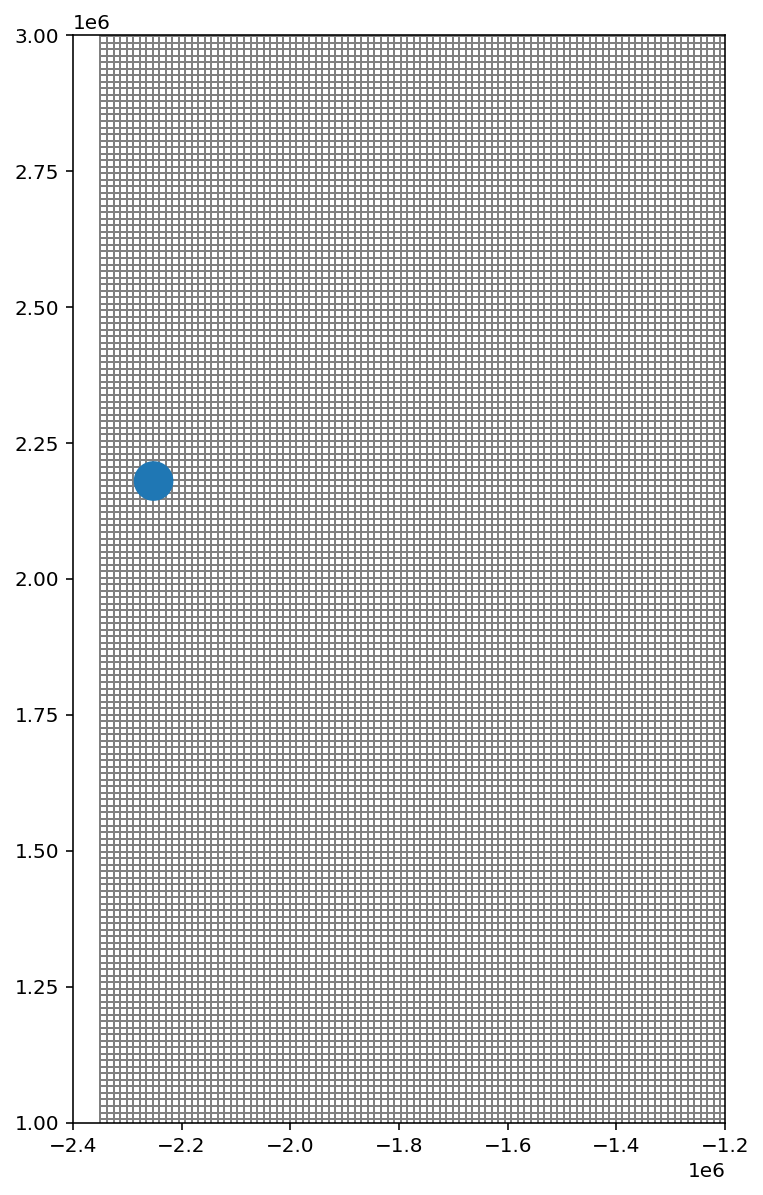

In [257]:
fig, ax= plt.subplots(figsize=(12, 10))
grid.plot(ax= ax, facecolor= 'None', edgecolor= 'grey');
firepts_gdf.loc[[6380]].plot(ax= ax);
ax.set_ylim(1.0e6, 3.0e6);
ax.set_xlim(-2.4e6, -1.2e6);

## Candidate regions

In [5]:
sierra_gdf= bailey_ecoprovince_shp(region= 'ca_sierra')
sierra_gdf= sierra_gdf.to_crs(epsg= 4326)
scoast_gdf= bailey_ecoprovince_shp(region= 'ca_south_coast')
scoast_gdf= scoast_gdf.to_crs(epsg= 4326)
ncoast_gdf= bailey_ecoprovince_shp(region= 'ca_north_coast')
ncoast_gdf= ncoast_gdf.to_crs(epsg= 4326)
ccoast_gdf= bailey_ecoprovince_shp(region= 'ca_cent_coast')
ccoast_gdf= ccoast_gdf.to_crs(epsg= 4326)

pnw_gdf= bailey_ecoprovince_shp(region= 'pnw_mts')
pnw_gdf= pnw_gdf.to_crs(epsg= 4326)
columbia_plateau_gdf= bailey_ecoprovince_shp(region= 'columbia_plateau')
columbia_plateau_gdf= columbia_plateau_gdf.to_crs(epsg= 4326)

nrockies_gdf= bailey_ecoprovince_shp(region= 'northern_rockies')
nrockies_gdf= nrockies_gdf.to_crs(epsg= 4326)
mrockies_gdf= bailey_ecoprovince_shp(region= 'middle_rockies')
mrockies_gdf= mrockies_gdf.to_crs(epsg= 4326)
srockies_gdf= bailey_ecoprovince_shp(region= 'southern_rockies')
srockies_gdf= srockies_gdf.to_crs(epsg= 4326)

col_plat_gdf= bailey_ecoprovince_shp(region= 'colorado_plateau')
col_plat_gdf= col_plat_gdf.to_crs(epsg= 4326)
am_semidesert_gdf= bailey_ecoprovince_shp(region= 'am_semidesert')
am_semidesert_gdf= am_semidesert_gdf.to_crs(epsg= 4326)
aznm_mts_gdf=  bailey_ecoprovince_shp(region= 'aznm_mts')
aznm_mts_gdf= aznm_mts_gdf.to_crs(epsg= 4326)

im_semidesert_gdf= bailey_ecoprovince_shp(region= 'im_semidesert')
im_semidesert_gdf= im_semidesert_gdf.to_crs(epsg= 4326)
im_desert_gdf= bailey_ecoprovince_shp(region= 'im_desert')
im_desert_gdf= im_desert_gdf.to_crs(epsg= 4326)
ch_desert_gdf= bailey_ecoprovince_shp(region= 'ch_desert')
ch_desert_gdf= ch_desert_gdf.to_crs(epsg= 4326)

ngreat_plains_gdf= bailey_ecoprovince_shp(region= 'northern_great_plains')
ngreat_plains_gdf= ngreat_plains_gdf.to_crs(epsg= 4326)
high_plains_gdf= bailey_ecoprovince_shp(region= 'high_plains')
high_plains_gdf= high_plains_gdf.to_crs(epsg= 4326)
sw_table_gdf= bailey_ecoprovince_shp(region= 'sw_tablelands')
sw_table_gdf= sw_table_gdf.to_crs(epsg= 4326)

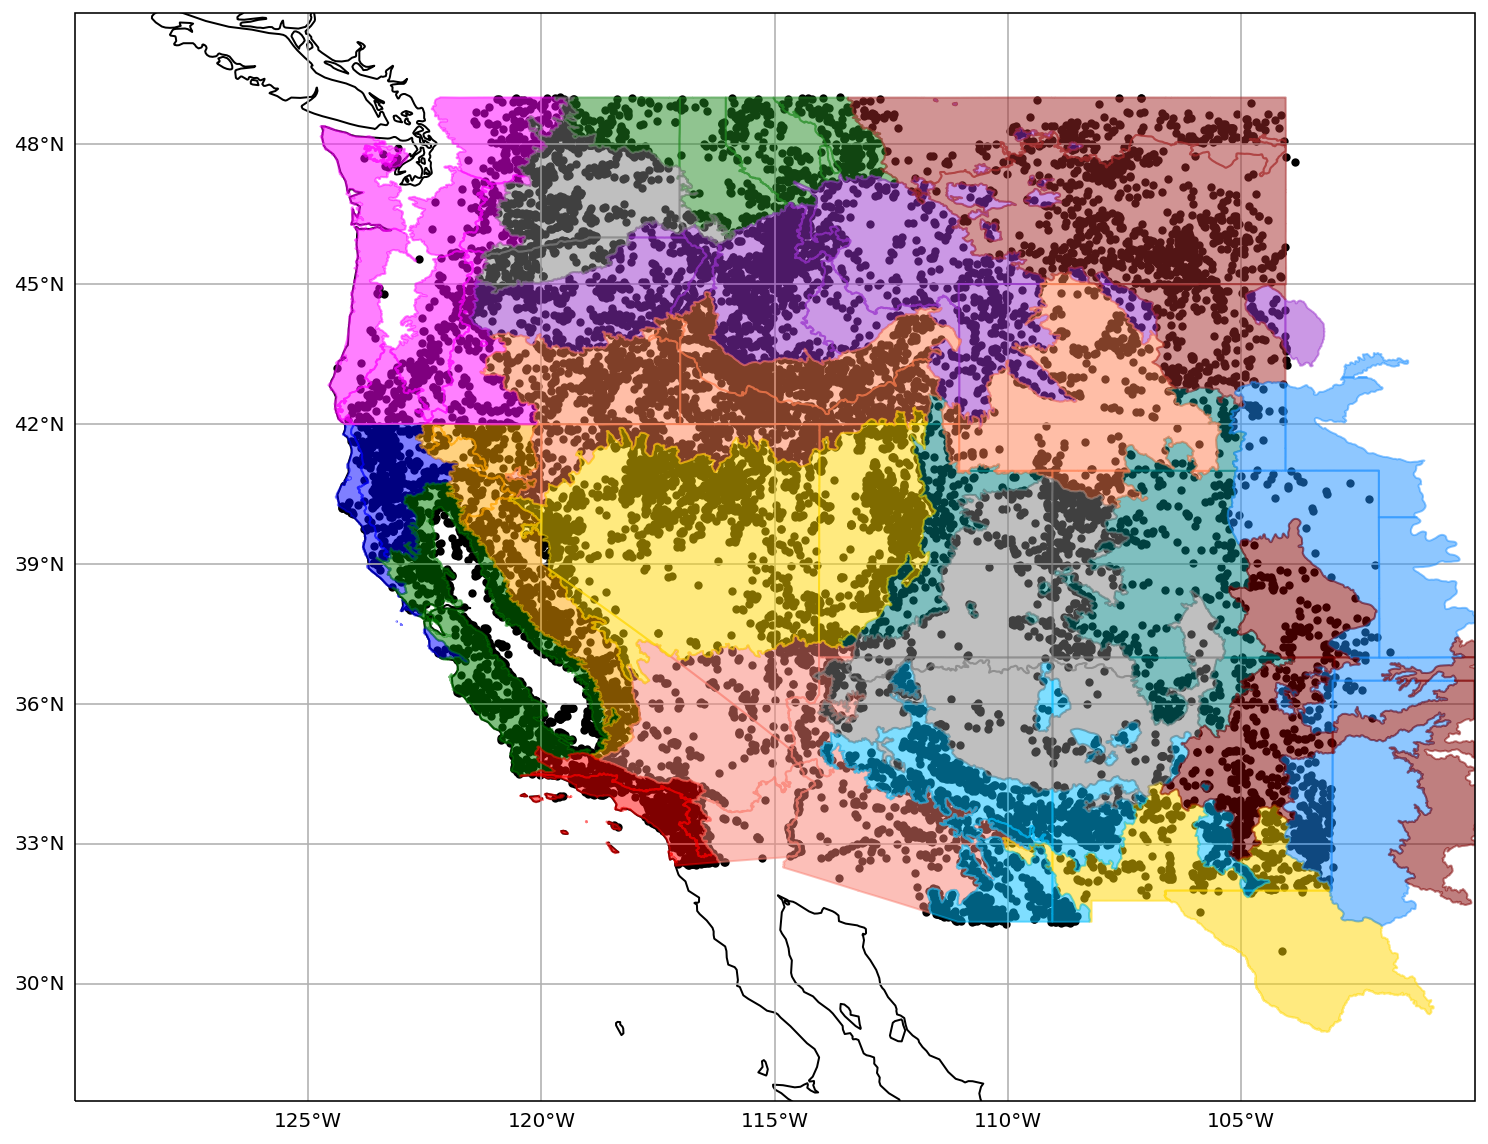

In [12]:
extent = [-130, -100, 27.5, 50] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
colors= np.random.rand(14)

fig= plt.figure(figsize=(14, 10), )
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
#ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor= cfeature.COLORS['water']);
ax.add_geometries(ncoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'blue', alpha= 0.5, zorder= 1)
ax.add_geometries(ccoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'green', alpha= 0.5, zorder= 2)
ax.add_geometries(sierra_gdf.geometry, crs= ccrs.PlateCarree(), color= 'orange', alpha= 0.5, zorder= 2)
ax.add_geometries(scoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'red', alpha= 0.5, zorder= 2)
ax.add_geometries(pnw_gdf.geometry, crs= ccrs.PlateCarree(), color= 'magenta', alpha= 0.5, zorder= 2)
ax.add_geometries(nrockies_gdf.geometry, crs= ccrs.PlateCarree(), color= 'forestgreen', alpha= 0.5, zorder= 2)
ax.add_geometries(mrockies_gdf.geometry, crs= ccrs.PlateCarree(), color= 'darkorchid', alpha= 0.5, zorder= 2)
ax.add_geometries(srockies_gdf.geometry, crs= ccrs.PlateCarree(), color= 'teal', alpha= 0.5, zorder= 2)
ax.add_geometries(am_semidesert_gdf.geometry, crs= ccrs.PlateCarree(), color= 'salmon', alpha= 0.5, zorder= 2)
ax.add_geometries(im_semidesert_gdf.geometry, crs= ccrs.PlateCarree(), color= 'coral', alpha= 0.5, zorder= 2)
ax.add_geometries(im_desert_gdf.geometry, crs= ccrs.PlateCarree(), color= 'gold', alpha= 0.5, zorder= 2)
ax.add_geometries(ch_desert_gdf.geometry, crs= ccrs.PlateCarree(), color= 'gold', alpha= 0.5, zorder= 2)
ax.add_geometries(aznm_mts_gdf.geometry, crs= ccrs.PlateCarree(), color= 'deepskyblue', alpha= 0.5, zorder= 2)
ax.add_geometries(ngreat_plains_gdf.geometry, crs= ccrs.PlateCarree(), color= 'brown', alpha= 0.5, zorder= 2)
ax.add_geometries(columbia_plateau_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(high_plains_gdf.geometry, crs= ccrs.PlateCarree(), color= 'dodgerblue', alpha= 0.5, zorder= 2)
ax.add_geometries(col_plat_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(sw_table_gdf.geometry, crs= ccrs.PlateCarree(), color= 'maroon', alpha= 0.5, zorder= 2)

ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree())

gl= ax.gridlines(draw_labels=True);
#gl.xlocator = mticker.FixedLocator([-116, -117, -118, -119, -120, -121, -122, -123, -124])
#gl.ylocator = mticker.FixedLocator([34, 36, 38, 40, 42])
gl.top_labels = False
gl.right_labels = False
#plt.savefig(outfilepath + 'all_regions.jpg', bbox_inches='tight', dpi= 200);

## Monthly fire frequency

In [5]:
tot_months= 36*12
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([1984, 1991, 1998, 2005, 2012, 2019]) #np.linspace(1984, 2019, 6, dtype= int)

ind_grid= [[1, 2, 3], [5, 6, 7], [8, 9, 11], [12, 13, 14]]
reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains"}

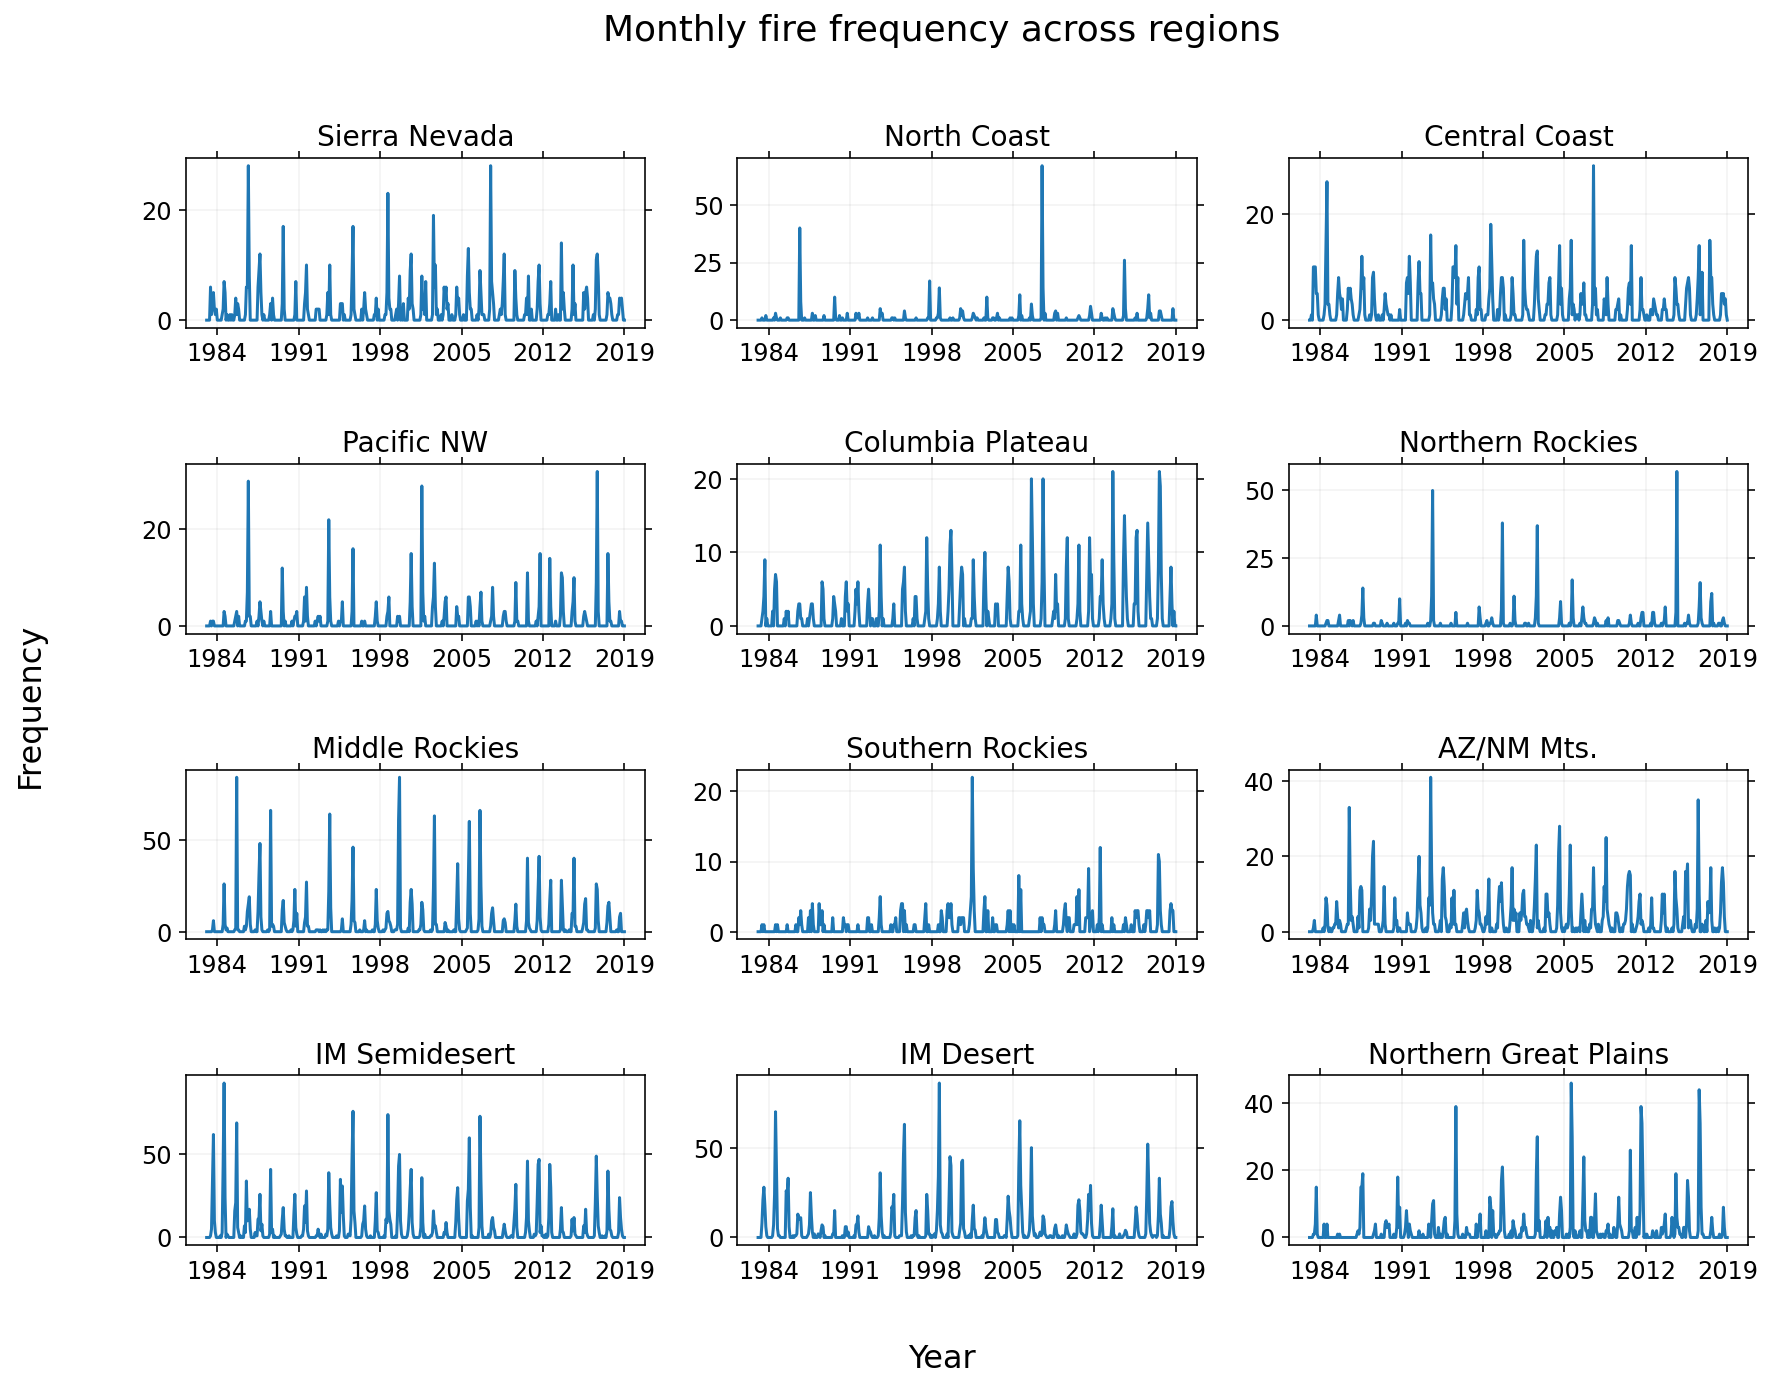

In [6]:
fig, ax= plt.subplots(4, 3, figsize=(14, 10))
plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(4):
    for j in range(3):
        ax[i, j].plot(month_arr, mon_fire_freq(wildfiredf= wildfire_df, regindx= ind_grid[i][j]).flatten());
        ax[i, j].set_title(reg_name[ind_grid[i][j]], fontsize= 14);
        
        ax[i, j].set_xticks((year_arr - 1984 + 1)*12 - 1);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

#plt.savefig(outfilepath + 'all_region_frequency.pdf', bbox_inches='tight');

## Sandbox

### Consistency checks

* Time series of annual burned area across all regions
* Scatter plot for a given year (in this case 2018) along with regional polygon
* Correlation in years where the VPD is above the 30 year climate mean

In [71]:
sierra_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 1].groupby(['final_year'])
ncoast_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 2].groupby(['final_year'])
ccoast_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 3].groupby(['final_year'])
scoast_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 4].groupby(['final_year'])

In [79]:
#consistency check for a given year, 1984, before generalizing to all years

tmp_burnarea_arr= []
tmp_burnarea_arr.append(sierra_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_burnarea_arr.append(ncoast_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_burnarea_arr.append(ccoast_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_burnarea_arr.append(scoast_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_ca_ann_burnarea= np.sum(np.hstack(tmp_burnarea_arr))/100

print("Total CA burned area (in km^2): %.2f"%tmp_ca_ann_burnarea)

Total CA burned area (in km^2): 633.43


In [81]:
sierra_ann_burnarea_check= np.asarray(([np.sum(sierra_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(sierra_ann_burnarea_group.groups.keys())]))
ncoast_ann_burnarea_check= np.asarray(([np.sum(ncoast_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(ncoast_ann_burnarea_group.groups.keys())]))
ccoast_ann_burnarea_check= np.asarray(([np.sum(ccoast_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(ccoast_ann_burnarea_group.groups.keys())]))
scoast_ann_burnarea_check= np.asarray(([np.sum(scoast_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(scoast_ann_burnarea_group.groups.keys())]))

ca_ann_burnarea_check= sierra_ann_burnarea_check + ncoast_ann_burnarea_check + ccoast_ann_burnarea_check + scoast_ann_burnarea_check

In [85]:
np.sum(ca_ann_burnarea_check[:-2])

54733.043600000005

In [89]:
np.sum(wildfire_df['final_area_ha'])/100

353303.0085

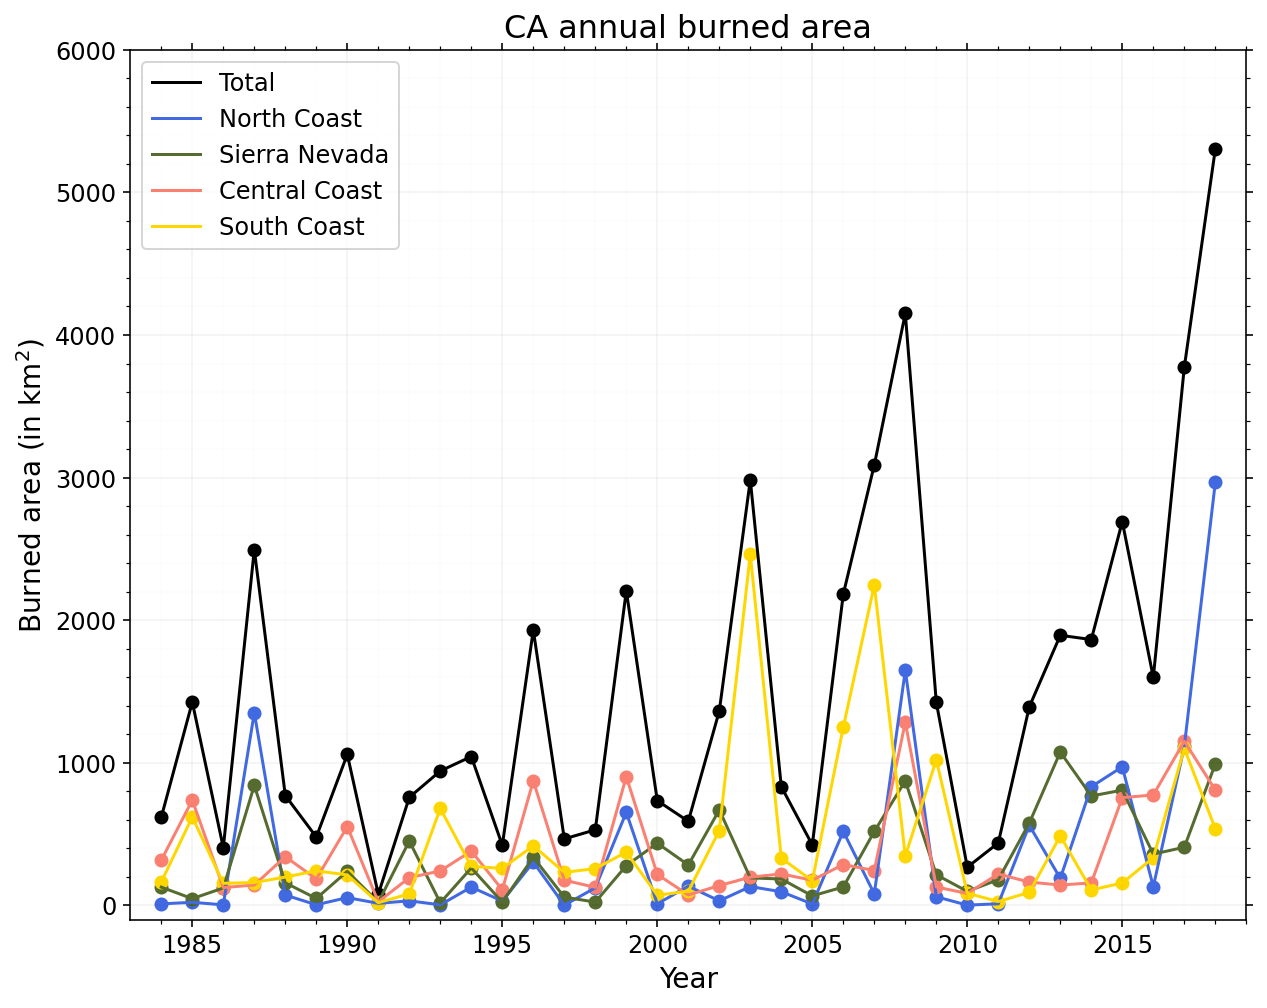

In [73]:
fig, ax= plt.subplots(figsize=(10, 8))

tot_months= len(ca_ann_burnarea_check) - 2
ax.scatter(np.linspace(1984, 2018, tot_months), ca_ann_burnarea_check[:-2], color= 'black');
ax.plot(np.linspace(1984, 2018, tot_months), ca_ann_burnarea_check[:-2], color= 'black', label= 'Total');
ax.scatter(np.linspace(1984, 2018, tot_months), ncoast_ann_burnarea_check[:-2], color= 'royalblue');
ax.plot(np.linspace(1984, 2018, tot_months), ncoast_ann_burnarea_check[:-2], color= 'royalblue', label= 'North Coast');
ax.scatter(np.linspace(1984, 2018, tot_months), sierra_ann_burnarea_check[:-2], color= 'darkolivegreen');
ax.plot(np.linspace(1984, 2018, tot_months), sierra_ann_burnarea_check[:-2], color= 'darkolivegreen', label= 'Sierra Nevada');
ax.scatter(np.linspace(1984, 2018, tot_months), ccoast_ann_burnarea_check[:-2], color= 'salmon');
ax.plot(np.linspace(1984, 2018, tot_months), ccoast_ann_burnarea_check[:-2], color= 'salmon', label= 'Central Coast');
ax.scatter(np.linspace(1984, 2018, tot_months), scoast_ann_burnarea_check[:-2], color= 'gold');
ax.plot(np.linspace(1984, 2018, tot_months), scoast_ann_burnarea_check[:-2], color= 'gold', label= 'South Coast');

ax.set_xlim(1983, 2019);
ax.set_xlabel(r'Year', fontsize= 14);
ax.set_ylim(-100, 6000);
ax.set_ylabel(r'Burned area (in ${\rm km}^2$)', fontsize= 14);

plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.legend(loc='upper left', frameon=True, fontsize=12);

ax.set_title(r'CA annual burned area', fontsize= 16);
#plt.savefig(outfilepath + 'ca_ann_burned_area.pdf', bbox_inches='tight');

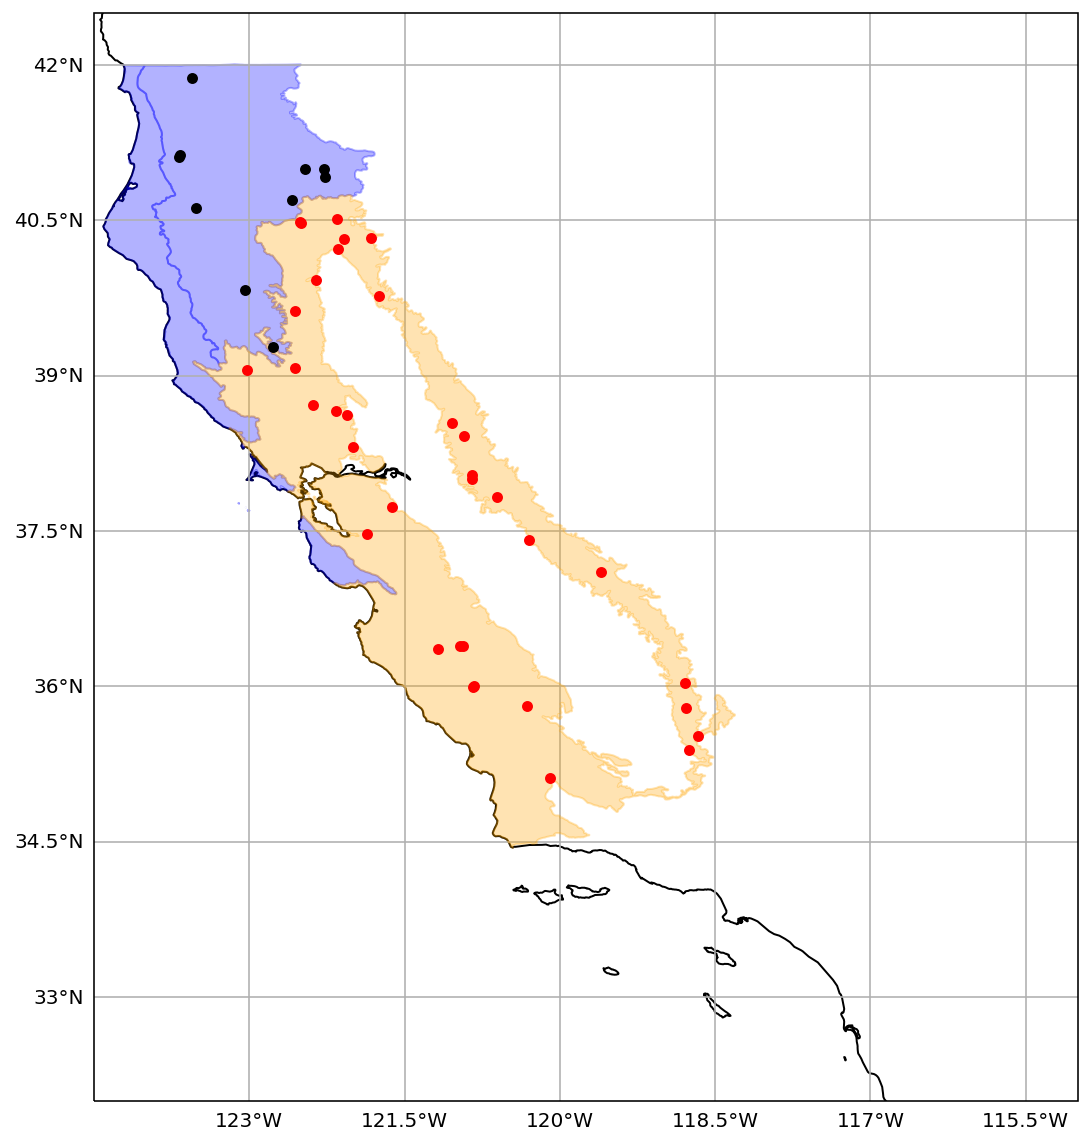

In [153]:
extent = [-124.5, -115, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
#ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor= cfeature.COLORS['water']);
ax.add_geometries(ncoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'blue', alpha= 0.3, zorder= 1)
ax.add_geometries(ccoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'orange', alpha= 0.3, zorder= 2)
ax.scatter(ncoast_ann_burnarea_group.get_group(2018)['final_lon'], ncoast_ann_burnarea_group.get_group(2018)['final_lat'], \
                                                        c= 'black', s= 20, transform=ccrs.PlateCarree(), zorder= 10)
ax.scatter(ccoast_ann_burnarea_group.get_group(2018)['final_lon'], ccoast_ann_burnarea_group.get_group(2018)['final_lat'], \
                                                        c= 'red', s= 20, transform=ccrs.PlateCarree(), zorder= 10)
# CS = ax.contourf(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(burnarea_ccoast_data.values[ind_2018], axis= 0), cmap=plt.cm.inferno, zorder= 20)
# cbar= fig.colorbar(CS, ax= ax, shrink= 0.8)
# cbar.ax.set_ylabel(r'Burned area (in ${\rm km}^2$)', fontsize= 14, labelpad= 10, rotation= 270)

gl= ax.gridlines(draw_labels=True);
#gl.xlocator = mticker.FixedLocator([-116, -117, -118, -119, -120, -121, -122, -123, -124])
#gl.ylocator = mticker.FixedLocator([34, 36, 38, 40, 42])
gl.top_labels = False
gl.right_labels = False

#plt.savefig(outfilepath + 'ca_nccoast_fires.pdf', bbox_inches='tight');

In [28]:
freq_sierra= mon_fire_freq(wildfiredf= wildfire_df, regindx= 1, threshold= False).flatten()
freq_pnw= mon_fire_freq(wildfiredf= wildfire_df, regindx= 5, threshold= False).flatten()
vpd_sierra= clim_pred_var(pred_file_indx= 2, pred_seas_indx= 1, regindx= 1, burnarr_len= 10)

sum_indx_1, sum_indx_2= tindx_func(startmon= 3, duration= 8)
sum_freq_sierra= np.asarray([np.sum(freq_sierra[sum_indx_1[i]:sum_indx_2[i]]) for i in range(len(sum_indx_1))])
sum_freq_pnw= np.asarray([np.sum(freq_pnw[sum_indx_1[i]:sum_indx_2[i]]) for i in range(len(sum_indx_1))])
ext_flag= np.where(vpd_sierra >= np.mean(vpd_sierra))

vpd_sierra= vpd_sierra[ext_flag]
sum_freq_sierra= sum_freq_sierra[ext_flag]

pred_var_sierra, pred_freq_sierra, r_sierra= uni_lsq_regression_model(sum_freq_sierra, pred_file_indx= 2, pred_seas_indx= 1, regindx= 1, freq_flag= True)
pred_var_pnw, pred_freq_pnw, r_pnw= uni_lsq_regression_model(sum_freq_pnw, pred_file_indx= 2, pred_seas_indx= 1, regindx= 5, freq_flag= True)

np.sqrt(r_sierra), np.sqrt(r_pnw)

### Sliding window tests

In [24]:
test_arr= np.asarray([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])

In [25]:
sliding_window_view(test_arr, (2, 2), axis= (0, 1))

array([[[[ 1,  2],
         [ 5,  6]],

        [[ 2,  3],
         [ 6,  7]],

        [[ 3,  4],
         [ 7,  8]]],


       [[[ 5,  6],
         [ 9, 10]],

        [[ 6,  7],
         [10, 11]],

        [[ 7,  8],
         [11, 12]]],


       [[[ 9, 10],
         [13, 14]],

        [[10, 11],
         [14, 15]],

        [[11, 12],
         [15, 16]]]])

In [28]:
np.mean(sliding_window_view(test_arr, (2, 2), axis= (0, 1)), axis= (2, 3))

array([[ 3.5,  4.5,  5.5],
       [ 7.5,  8.5,  9.5],
       [11.5, 12.5, 13.5]])

In [27]:
np.mean(sliding_window_view(test_arr, (2, 2), axis= (0, 1)), axis= (2, 3))[::2, ::2]

array([[ 3.5,  5.5],
       [11.5, 13.5]])